<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/2/MLP_NN_ModelEvaluationa%26Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
plt.style.use('seaborn-talk')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

import requests
import io

from matplotlib import rcParams
# rcParams['figure.figsize'] = 15,7
plt.rc('figure', figsize=(12,7) )         # Image size


## GPU

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Fri Dec  3 22:58:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    72W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13298242124229354786
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9763809918680399550
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

tf.config.experimental.set_memory_growth(gpus[0] , True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data: Farsi Hand-written digits classification

In [2]:
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/Farsi_digits_X.npz'
s=requests.get(url, stream=True).content
X = np.load(io.BytesIO(s) )['arr_0']
url = 'https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/Data/Farsi_digits_Y.npz'
s=requests.get(url, stream=True).content
Y = np.load(io.BytesIO(s) )['arr_0']

# X = np.load('X.npz')['arr_0']
# Y = np.load('Y.npz')['arr_0']


from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state = 0 )

In [3]:
print('Each image is of the form: {}'.format(X[0].shape ) )

Each image is of the form: (32, 32)


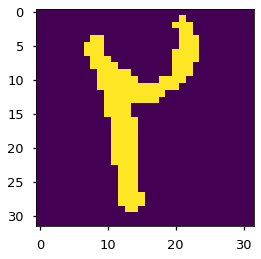

In [4]:
plt.imshow(X[20])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

## Pytorch

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

In [107]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32, 120)  
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.softmax(x, dim=1)

        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Simple Training

In [34]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[0.0868, 0.0919, 0.0976, 0.0932, 0.0996, 0.1030, 0.1098, 0.1297, 0.1046,
         0.0838]], grad_fn=<SoftmaxBackward0>)


In [57]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=.01, betas=(0.9, 0.999))

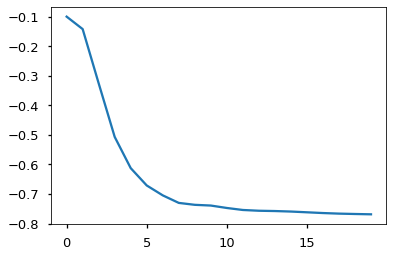

In [36]:
epochs = 20

#We also need to keep track of the loss. 
losses = []

for i in range(epochs):
    #Clear the previous gradients
    optimizer.zero_grad()
    
    #Precit the output for Given input
    y_pred = net.forward(x_tr)
    
    loss = F.nll_loss(y_pred, y_tr)
    losses += [loss]


    loss.backward()
    optimizer.step()
    
    
plt.plot(losses)
plt.show()

7224
This sample is a 0.



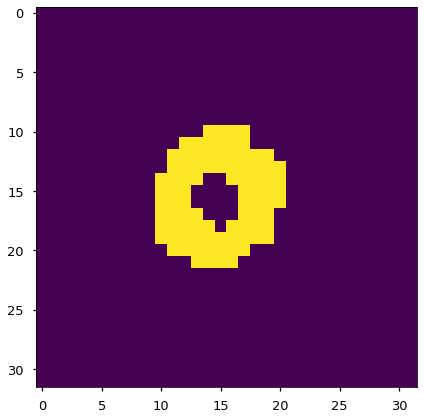

In [99]:
ind = np.random.randint(0, len(x_ts))
print(ind)
plt.imshow(x_ts[ind] )
pred = net.forward(x_ts[ind].view(-1,32,32)).argmax()
print(f'This sample is a {pred}.\n')

## Minibatch

Let's add mini-batch optimization and keep track of the accuracy.

In [96]:
del net
net = Net()
optimizer = optim.Adam(net.parameters(), lr=.01, betas=(0.9, 0.999))

In [97]:
x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# del net
net = Net().to(device)

x_tr = x_tr.to(device)
x_ts = x_ts.to(device)

y_tr = y_tr.to(device)
y_ts = y_ts.to(device)

In [99]:
(net.forward(x_ts).argmax(axis=1)==y_ts).sum()/len(y_ts)
# net.forward(x_ts).argmax(axis=1)

tensor(0.1428, device='cuda:0')

In [112]:
n_epoch=20
btch_size = 1000

In [113]:
## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)

### Data Loaders

torch.Size([100, 32, 32])
tensor(8)


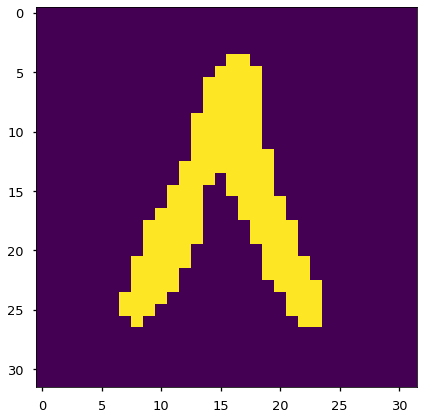

In [183]:
for x, y in train_loader:
  print(x.size() )
  plt.imshow(x[0].numpy())
  print(y[0])
  break

### Training

In [114]:
# epochs = 3
# batch_size = 500
n_s = len(x_tr)
n_ts = len(x_ts)


#We also need to keep track of the loss. 
sample_rate = 20
training_losses = []
test_losses = []

training_accuracy = []
test_accuracy = []
for i in range(n_epoch):
  print(f'Starting {i} epoch.')
  # print(len(training_losses))
  ind = 0

  for X_batch, Y_batch in train_loader:
    X_batch = X_batch.to(device)
    Y_batch = Y_batch.to(device)
    ind += 1
    #Clear the previous gradients
    optimizer.zero_grad()
   
    #Precit the output for Given input
    y_pred = net.forward(X_batch)
    
    loss = F.nll_loss(y_pred, Y_batch)
    loss.backward()
    optimizer.step()

    ## Every sample_rate, we record the loss and accuracy. 
    if ind%(int(n_s/btch_size/sample_rate))==0:
      y_tr_pred = net.forward(x_tr)
      training_losses += [F.nll_loss( y_tr_pred, y_tr).item() ]
      training_accuracy += [torch.sum( y_tr == 
                                      torch.argmax( y_tr_pred, axis=1 ) ).item()/n_s ]

      # print(F.nll_loss( net.forward(x_ts) , y_ts) )
      y_ts_pred = net.forward(x_ts)
      test_losses += [F.nll_loss( y_ts_pred, y_ts).item() ]
      test_accuracy += [torch.sum( y_ts == 
                                      torch.argmax( y_ts_pred, axis=1 )).item()/n_ts ]





Starting 0 epoch.
Starting 1 epoch.
Starting 2 epoch.
Starting 3 epoch.
Starting 4 epoch.
Starting 5 epoch.
Starting 6 epoch.
Starting 7 epoch.
Starting 8 epoch.
Starting 9 epoch.
Starting 10 epoch.
Starting 11 epoch.
Starting 12 epoch.
Starting 13 epoch.
Starting 14 epoch.
Starting 15 epoch.
Starting 16 epoch.
Starting 17 epoch.
Starting 18 epoch.
Starting 19 epoch.


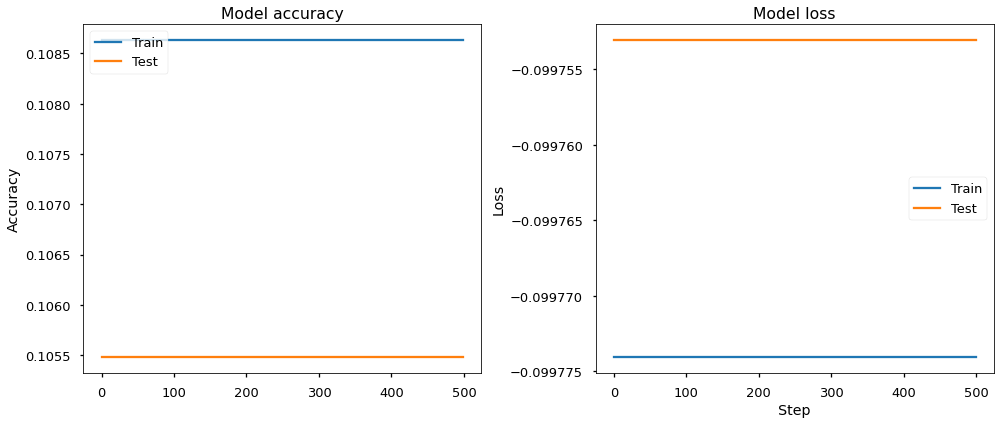

In [115]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

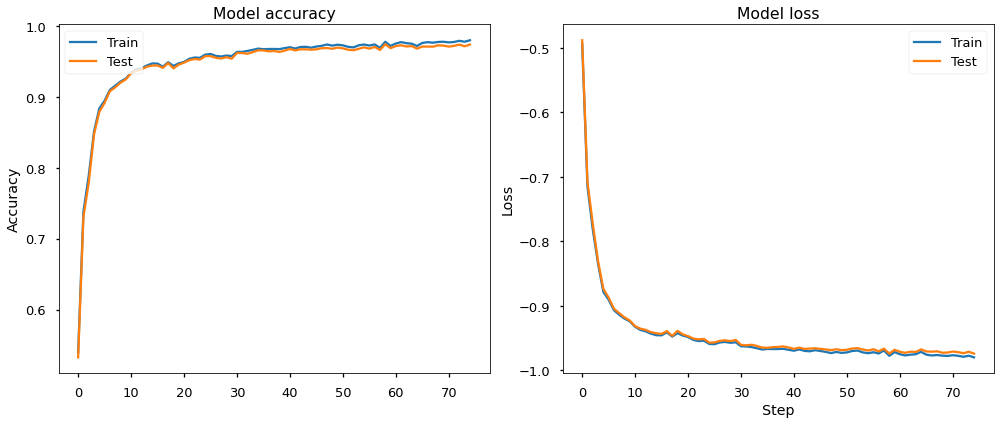

In [24]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss', xlabel = 'Step')
plt.plot(training_losses)
plt.plot(test_losses )
plt.legend(['Train', 'Test'], loc=0)

plt.tight_layout()
plt.show()

## GPU

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_epoch=20
btch_size = 1000

x_tr = torch.from_numpy(X_train).float()
x_ts = torch.from_numpy(X_test).float()

y_tr = torch.from_numpy(Y_train)
y_ts = torch.from_numpy(Y_test)

## Training data
training_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=btch_size, shuffle=True)

## Test data
test_dataset = torch.utils.data.TensorDataset(x_ts, y_ts)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=btch_size, shuffle=True)




In [8]:
n_w, n_h = x_tr[0].size()
n_w, n_h

(32, 32)

In [12]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, n_l_list, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, n_l_list[0]) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_l_list[0], n_l_list[1]) 
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(n_l_list[1], num_classes)  
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.softmax(x, dim=1)
        return output

    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [17]:
n_w, n_h = x_tr[0].size()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = NeuralNet(n_w * n_h, [100,80], 10).to(device)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

# Train the model
total_step = len(train_loader)
for epoch in range(n_epoch):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, n_w*n_h).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, n_w*n_h).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 97.66296701578865 %


## Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
Y_test[0]

1

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
X_train.shape

(76764, 32, 32)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,Y_train, validation_split=0.25, epochs=5, batch_size=500)

Epoch 1/5
116/116 [==============================] - 4s 5ms/step - loss: 0.7007 - accuracy: 0.8000 - val_loss: 0.1671 - val_accuracy: 0.9534
Epoch 2/5
116/116 [==============================] - 1s 4ms/step - loss: 0.1431 - accuracy: 0.9600 - val_loss: 0.1235 - val_accuracy: 0.9651
Epoch 3/5
116/116 [==============================] - 0s 4ms/step - loss: 0.1008 - accuracy: 0.9724 - val_loss: 0.1012 - val_accuracy: 0.9709
Epoch 4/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0747 - accuracy: 0.9795 - val_loss: 0.0880 - val_accuracy: 0.9752
Epoch 5/5
116/116 [==============================] - 0s 4ms/step - loss: 0.0610 - accuracy: 0.9835 - val_loss: 0.0791 - val_accuracy: 0.9764


In [ ]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(Y_test, Y_predicted)
print(cm)

[[2517    0    0    0    2   14    0    2    1    0]
 [   2 2491    9    0    1    1    2    3    0    2]
 [   2   15 2431   19    8    0    8    9    0    8]
 [   1    0   92 2414   34    1    1    1    0    0]
 [   3   10   27   63 2544   18    7   13    1    6]
 [   8    3    1    3    3 2466    2    3    6    2]
 [   3    5   13    0    4    3 2524   12    1   43]
 [   3    4    5    0    4    4    2 2586    0    0]
 [   3    3    1    1    2    2    6    1 2511   18]
 [   0   16    4    0    3    0    9    0   10 2502]]


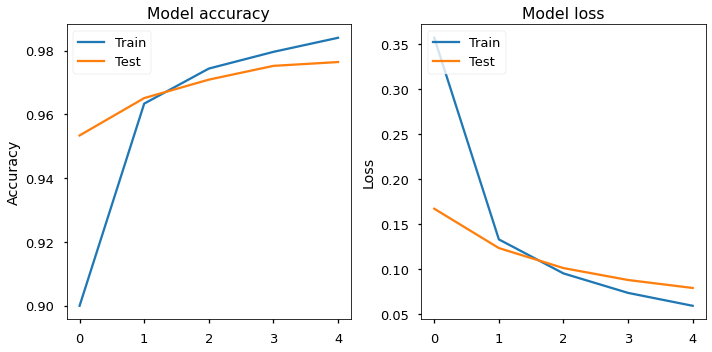

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)
print(Y[4])
Y_oh[4]

3


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(128, activation= 'relu' ),
    keras.layers.Dense(10, activation='softmax'  )
])

## We need to change the loss function for the one-hot encoding
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,Y_train, 
                    validation_split=0.25, 
                    epochs=50, 
                    batch_size=500, 
                    verbose=0)

In [ ]:
Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
print(cm)


[[2521    0    0    1    0   13    0    1    0    0]
 [   1 2502    3    0    2    0    1    0    0    2]
 [   3    8 2439   24   11    0    8    4    0    3]
 [   1    0   44 2473   24    1    1    0    0    0]
 [   3    7   14   33 2614    8    5    5    1    2]
 [   8    1    0    3    7 2468    4    1    3    2]
 [   3    3    6    0    3    1 2569    4    4   15]
 [   4    3    1    1    3    5    5 2586    0    0]
 [   2    4    0    1    1    1    3    1 2523   12]
 [   0    9    2    0    1    0   15    0    4 2513]]


In [ ]:
model.predict(X_test[:1]).argmax(axis=1)

array([1])

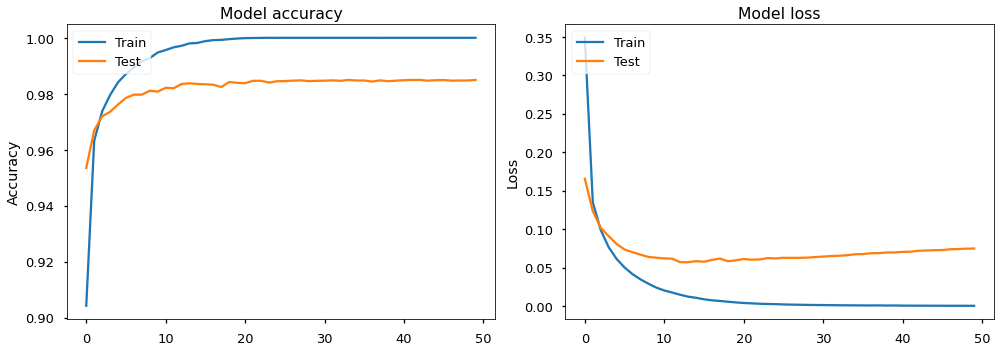

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Handling Overfitting


In [ ]:
n_s = 100000
model.reset_states()
history_ovfit = model.fit(X_train[:n_s],Y_train[:n_s], 
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=10 , 
                          batch_size=256, 
                          verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0403 - accuracy: 0.9895 - val_loss: 0.0715 - val_accuracy: 0.9840
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0587 - val_accuracy: 0.9863
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0604 - val_accuracy: 0.9864
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0573 - val_accuracy: 0.9872
Epoch 5/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0586 - val_accuracy: 0.9876
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0597 - val_accuracy: 0.9874
Epoch 7/10
300/300 [==============================] - 1s 4ms/step - loss: 7.6325e-04 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.9878
Ep

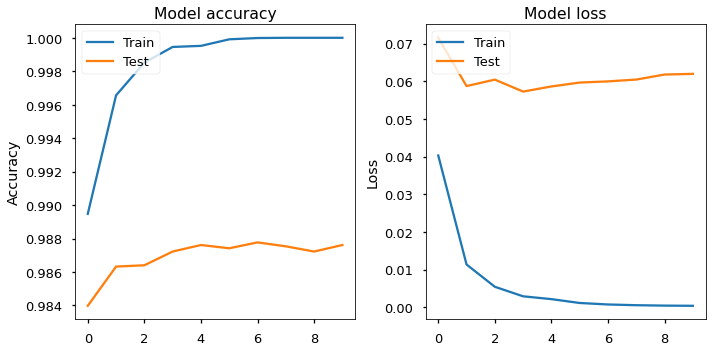

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit.history['accuracy'])
plt.plot(history_ovfit.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit.history['loss'])
plt.plot(history_ovfit.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
Y_oh = keras.utils.to_categorical(Y, num_classes=10, dtype=int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)


In [ ]:
model_ovfit1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_ovfit1.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_ovfit1.build([None, 2])
model_ovfit1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1290      
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


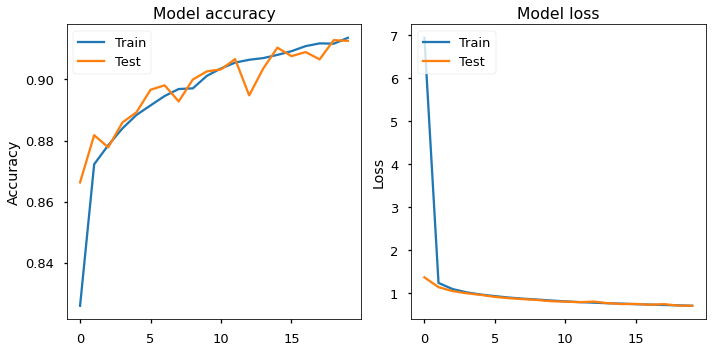

In [ ]:
n_s = 1000000
history_ovfit1 =  model_ovfit1.fit(X_train[:n_s],Y_train[:n_s], 
#                           validation_split=0.05,
                          validation_data = (X_test, Y_test),
                          epochs=20 , 
                          batch_size=256, 
                          verbose=0)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit1.history['accuracy'])
plt.plot(history_ovfit1.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit1.history['loss'])
plt.plot(history_ovfit1.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print(np.argmax(Y_test[:3],axis=1))
model_ovfit1.predict(X_test[:3]).argmax(axis=1)
set(model_ovfit1.predict(X_test).argmax(axis=1))

[1 8 6]


{9}

Epoch 1/20
300/300 [==============================] - 2s 5ms/step - loss: 1.1514 - accuracy: 0.6099 - val_loss: 0.1574 - val_accuracy: 0.9555
Epoch 2/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2543 - accuracy: 0.9302 - val_loss: 0.1150 - val_accuracy: 0.9672
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1964 - accuracy: 0.9467 - val_loss: 0.0967 - val_accuracy: 0.9722
Epoch 4/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1510 - accuracy: 0.9571 - val_loss: 0.0906 - val_accuracy: 0.9757
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1389 - accuracy: 0.9602 - val_loss: 0.0824 - val_accuracy: 0.9771
Epoch 6/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1330 - accuracy: 0.9630 - val_loss: 0.0804 - val_accuracy: 0.9779
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.1204 - accuracy: 0.9662 - val_loss: 0.0750 - val_accuracy: 0.9797
Epoch 

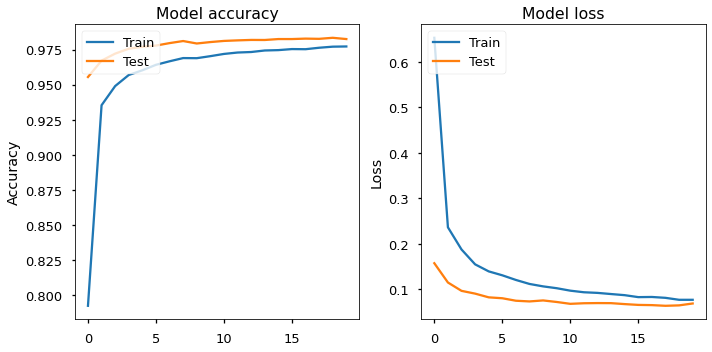

In [ ]:
model_ovfit2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation=tf.nn.relu ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


model_ovfit2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ovfit2 = model_ovfit2.fit(X_train[:n_s],Y_train[:n_s], 
                                  validation_data = (X_test, Y_test),
#                                   validation_split=0.05, 
                                  epochs=20 , 
                                  batch_size=256, verbose=1)

# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history_ovfit2.history['accuracy'])
plt.plot(history_ovfit2.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history_ovfit2.history['loss'])
plt.plot(history_ovfit2.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

***Assignment*** Play with these models and their hyperparameters to get a sense of how they affect the NN.

## Full Pipeline

### Cross-Validation

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [ ]:
def model_fn():
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),    
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1) ),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
epch = 10
batch_sz = 500

from sklearn.model_selection import KFold
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True)


loss = []
acc = []
val_loss = []
val_acc = []

# cross validate:
for train_index, val_index in kf.split(X):
    model = model_fn()
    hist = model.fit(X[train_index], Y[train_index],
                     epochs=epch,
                     batch_size=500,
                     validation_data = (X[val_index], Y[val_index]),
                     verbose=0)
    loss.append(hist.history['loss'])
    acc.append(hist.history['accuracy'])
    val_loss.append([hist.history['val_loss']])
    val_acc.append(hist.history['val_accuracy'])
    
loss = np.array(loss).reshape(n_folds, epch )    
acc = np.array(acc).reshape(n_folds, epch )       
val_loss = np.array(val_loss).reshape(n_folds, epch )      
val_acc  = np.array(val_acc).reshape(n_folds, epch )       

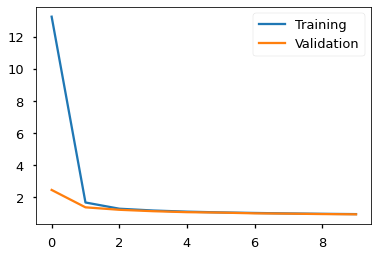

In [ ]:
loss_m = loss.mean(axis=0)
loss_s = loss.var(axis=0)


val_loss_m = val_loss.mean(axis=0)
val_loss_s = val_loss.var(axis=0)

plt.plot(loss_m, label = 'Training')
plt.fill_between(range(len(loss_m)),loss_m-loss_s/2, loss_m+loss_s/2)
plt.plot(val_loss_m, label = 'Validation')
plt.fill_between(range(len(loss_m)),val_loss_m-loss_s/2, val_loss_m+loss_s/2)
plt.legend(loc=0)
plt.show()

In [ ]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(ks_model, X, Y, cv=kfold)
print(results.mean())

185/185 [==============================] - 1s 3ms/step - loss: 1.0863 - accuracy: 0.8747
Epoch 5/10
185/185 [==============================] - 1s 3ms/step - loss: 1.0307 - accuracy: 0.8774
Epoch 6/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9866 - accuracy: 0.8791
Epoch 7/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9589 - accuracy: 0.8792
Epoch 8/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9314 - accuracy: 0.8814
Epoch 9/10
185/185 [==============================] - 1s 3ms/step - loss: 0.9105 - accuracy: 0.8828
Epoch 10/10
21/21 [==============================] - 0s 3ms/step - loss: 0.8872 - accuracy: 0.8837
Epoch 1/10
185/185 [==============================] - 1s 3ms/step - loss: 21.7063 - accuracy: 0.6687
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 1.5076 - accuracy: 0.8679
Epoch 3/10
185/185 [==============================] - 1s 3ms/step - loss: 1.2157 - accuracy: 0.8791
Epoch 4/10


In [ ]:
results

array([0.88100821, 0.89292693, 0.89057159, 0.90327311, 0.89643383,
       0.88754272, 0.90239376, 0.88617492, 0.88373232, 0.88998532])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

csv_logger = CSVLogger('training.log', append=True)
calls=[csv_logger, EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint('model_log', monitor='acc', save_best_only=True, mode='auto')]


In [ ]:
ks_model = KerasClassifier(build_fn=model_fn, epochs=10, batch_size=500, verbose=0  )
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0 )
results = cross_val_score(ks_model, X, Y, cv=kfold,
                      fit_params = {'callbacks': calls})
print(results.mean())


0.8922542532285055


In [ ]:
import pandas as pd
df = pd.read_csv('training.log')
df.groupby('epoch').mean()

,accuracy,loss
epoch,,
0,0.777454,13.280245
1,0.867018,1.675638
2,0.873090,1.282109
3,0.877511,1.168730
4,0.881014,1.099520
5,0.883573,1.053082
6,0.885181,1.016071
7,0.887867,0.985722
8,0.888141,0.963722


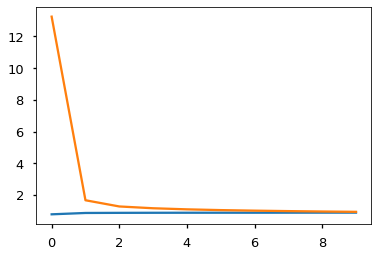

In [ ]:
plt.plot(df.groupby('epoch').mean())

### Tuning

In [ ]:
def model_fn(dense_layer_sizes, regularizations, dropouts, lr=.1):
    model = keras.Sequential() 
    
    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )
    
    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i], 
                                      activation=tf.nn.relu, 
                                      kernel_regularizer=keras.regularizers.l2(regularizations[i]) 
                                     ) )
        model.add(keras.layers.Dropout( dropouts[i] ) )
        
       
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
        
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    

    return model

mdl = model_fn([100, 30], [.001, .001], [.001, .001], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)               102500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 30)                3030      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_______________________________________________

In [ ]:
def model_fn(dense_layer_sizes, lr=.1):
    model = keras.Sequential() 
    
    model.add(  keras.layers.Flatten(input_shape=(32, 32)) )
    
    for i in range( len(dense_layer_sizes )):
        model.add( keras.layers.Dense( dense_layer_sizes[i], 
                                      activation=tf.nn.relu #, 
                                      # kernel_regularizer=keras.regularizers.l2(regularizations[i]) 
                                     ) )
        # model.add(keras.layers.Dropout( dropouts[i] ) )
        
       
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
        
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    

    return model

mdl = model_fn([100, 30], .1)
# mdl = model_fn([128], [.01], [.01])
mdl.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 100)               102500    
_________________________________________________________________
dense_107 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_108 (Dense)            (None, 10)                310       
Total params: 105,840
Trainable params: 105,840
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_train.shape

(76764, 10)

In [ ]:
btch_size = 500
epch = 3
history = mdl.fit(X_train, Y_train, batch_size=btch_size, epochs=epch )

Epoch 1/3
154/154 [==============================] - 1s 3ms/step - loss: 3.0966 - accuracy: 0.2302
Epoch 2/3
154/154 [==============================] - 1s 3ms/step - loss: 1.4589 - accuracy: 0.3688
Epoch 3/3
154/154 [==============================] - 1s 3ms/step - loss: 1.4039 - accuracy: 0.4468


In [ ]:
# Grid search over these:
dense_size_candidates = [(10, 40), (50) , (20) ]
# regularizations_candidates = [ (.01), (.01), (.001) ]
# dropouts_candidates = [  (.005), (.01), (.003) ]
lr_candidates = [.1]
# epch_list = [4, 10]
batch_size_candidates = 500

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
# from sklearn.model_selection import 

gs_classifier = KerasClassifier(model_fn, batch_size=500, epochs=5)


In [ ]:
validator = GridSearchCV(gs_classifier,
                         param_grid={'dense_layer_sizes': dense_size_candidates,
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [3],
                                    #  'regularizations': regularizations_candidates,
                                    #  'dropouts': dropouts_candidates,
                                     'lr': lr_candidates},
                         scoring='neg_log_loss',
                         n_jobs= 1,  )
validator.fit(X_train, Y_train)

Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.1302 - accuracy: 0.2106
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.5675 - accuracy: 0.3712
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.4028 - accuracy: 0.4360
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.4252 - accuracy: 0.1331
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 2.0549 - accuracy: 0.1869
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 2.0436 - accuracy: 0.1891
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 2.1963 - accuracy: 0.2215
Epoch 2/3
123/123 [==============================] - 0s 3ms/step - loss: 1.4566 - accuracy: 0.3992
Epoch 3/3
123/123 [==============================] - 0s 3ms/step - loss: 1.3532 - accuracy: 0.4463
Epoch 1/3
123/123 [==============================] - 1s 3ms/step - loss: 1.7422 - accuracy: 0.3871
Epoch 2/3


GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f23a84c2ed0>,
             iid='deprecated', n_jobs=1,
             param_grid={'dense_layer_sizes': [(10, 40), 50, 20], 'epochs': [3],
                         'lr': [0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [ ]:
print('The parameters of the best model are: ')
print(validator.best_params_)

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = validator.best_estimator_.model

The parameters of the best model are: 
{'dense_layer_sizes': (10, 40), 'epochs': 3, 'lr': 0.1}


In [ ]:
best_model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


### Keras Tuner

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt


     |████████████████████████████████| 71kB 3.4MB/s 


In [ ]:
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(32, 32)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, 
                               activation='relu', 
                               kernel_regularizer=keras.regularizers.l2(.05)))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, Y_train, 
             epochs=50, 
             batch_size = 100, 
             validation_split=0.2, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 23s]
val_accuracy: 0.9030808210372925

Best val_accuracy So Far: 0.9572721719741821
Total elapsed time: 00h 05m 07s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, 
                    epochs=30, 
                    batch_size = 100, 
                    validation_data=(X_test, Y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
768/768 [==============================] - 4s 4ms/step - loss: 4.4117 - accuracy: 0.8771 - val_loss: 0.4826 - val_accuracy: 0.9174
Epoch 2/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4849 - accuracy: 0.9205 - val_loss: 0.4528 - val_accuracy: 0.9350
Epoch 3/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4407 - accuracy: 0.9328 - val_loss: 0.4437 - val_accuracy: 0.9446
Epoch 4/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4161 - accuracy: 0.9370 - val_loss: 0.3972 - val_accuracy: 0.9417
Epoch 5/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3964 - accuracy: 0.9400 - val_loss: 0.3703 - val_accuracy: 0.9430
Epoch 6/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3762 - accuracy: 0.9443 - val_loss: 0.3698 - val_accuracy: 0.9503
Epoch 7/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3482 - accuracy: 0.9492 - val_loss: 0.3503 - val_accuracy: 0.9497
Epoch 

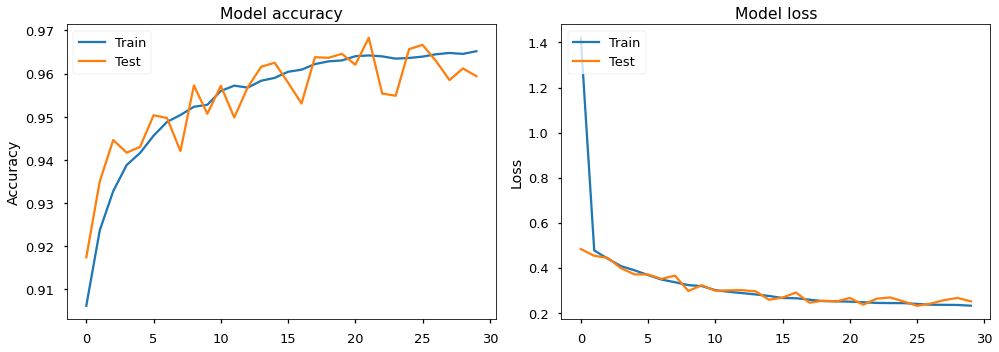

In [ ]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## Try this for the particle identification problem.

In [ ]:
import pandas as pd
url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )
 
'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [ ]:
n_s = len(data)
targets = list(set(data['id']))
# mini_data = data.sample(n_s, axis=0, random_state=0)
# data['target'] = data['id'].apply(lambda x: targets.index(x)) 
data['id'] = pd.Categorical(data.id)
# data.drop('id',axis=1, inplace=True)

data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [ ]:
from sklearn.model_selection import train_test_split
Y_oh = keras.utils.to_categorical(data.id.cat.codes, num_classes=4, dtype=int)
ind_to_keep = ['p', 'beta']
X = data[ind_to_keep].values

X_train, X_test, Y_train, Y_test = train_test_split( data[ind_to_keep], Y_oh, random_state=0)

In [ ]:
Y_train.shape

(3750000, 4)